In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from astropy.table import Table, Column, join, unique
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import pandas as pd
import numpy as np
import os
import string as s
import emcee
import math

from matplotlib.colors import ListedColormap

In [6]:
# deine the path to save the plots
plot_path = '/Users/Briana/Documents/Grad_School/HPS/Paper_Plots'

sns.set_context('paper')
sns.set_palette("colorblind")

# Build DataFrames for Fluxes and Metallicities for OII and OIII

In [7]:
#Build df of fluxes 
flux_o2 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/OII_norm_fluxes.csv')
flux_o3 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/OIII_norm_fluxes.csv')

flux_o2['Detect'] = '[OII]3727'
flux_o3['Detect'] = '[OIII]5007'

#df of with just HPS_name and corresponding ID
id_conv_o2 = flux_o2.loc[:,['HPS_name', 'ID']]
id_conv_o3 = flux_o3.loc[:,['HPS_name', 'ID']]

#Build df of metallicities
met_o2 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OII.csv')
met_o3 = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/hps_metallicty_measures_norm_OIII_w_RL.csv')

#add ID values as column in metallicity dfs
met_o2 = pd.merge(met_o2, id_conv_o2, on='HPS_name', how='left')
met_o3 = pd.merge(met_o3, id_conv_o3, on='HPS_name', how='left')

In [8]:
#read in a table to match redshift values
hps_z = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_z.dat')
hps_z = hps_z.loc[:,['HPS_name', 'z']]

#read in a table to match mass values 
hps_mass = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_mass.csv')
hps_mass['LogM_e'] = (hps_mass['LogM_eu'] + hps_mass['LogM_el'])/2.0

print hps_mass

    Unnamed: 0          HPS_name    LogM  LogM_eu  LogM_el  LogM_e
0            0  HPS030638+000015  10.800    0.127    0.073  0.1000
1            1  HPS022127-043019   9.989    0.100    0.066  0.0830
2            2  HPS030649+000314   8.712    0.098    0.068  0.0830
3            3  HPS030657+000139   9.472    0.113    0.082  0.0975
4            4  HPS100018+021818  10.374    0.072    0.044  0.0580
5            5  HPS100018+021426   9.420    0.076    0.047  0.0615
6            6  HPS100032+021356   9.472    0.090    0.052  0.0710
7            7  HPS100045+021823   9.554    0.075    0.050  0.0625
8            8  HPS123636+621135   9.799    0.071    0.039  0.0550
9            9  HPS123641+621131   9.234    0.085    0.055  0.0700
10          10  HPS123648+621426   9.902    0.075    0.047  0.0610
11          11  HPS123659+621404   9.143    0.069    0.049  0.0590
12          12  HPS123702+621123   9.988    0.067    0.043  0.0550
13          13  HPS030630+000128   9.174    0.108    0.074  0.

In [9]:
#Combine the OII and OIII objects in flux and metallicity
flux_frames = [flux_o2, flux_o3]
flux = pd.concat(flux_frames, sort=True)
flux.set_index(np.arange(len(flux)), inplace=True)

met_frames = [met_o2, met_o3]
met = pd.concat(met_frames, sort=True)
met.set_index(np.arange(len(met)), inplace=True)

#merge the flux and metallicity tables 
hps = pd.merge(flux, met, on='HPS_name', how='outer')
#merge this table with the z table to add redshift values
hps = pd.merge(hps, hps_z, on='HPS_name', how='outer')
print(hps.met_err)
#merge this table with the mass table 
hps = pd.merge(hps, hps_mass, on='HPS_name', how='right')

#print hps.loc[:,['HPS_name', '[OII]3727', 'E(B-V)', 'metallicity', 'z', 'LogM']]
#print hps.loc[:,[ u'LogM', u'LogM_eu', 'met_err']]
print(hps.columns)

0      [0.1019263391564671, 0.14690961521111134]
1     [0.09966931620980723, 0.15414919193669085]
2      [0.3743872268129822, 0.16117377260803867]
3      [0.1351555003586924, 0.18144649826293247]
4      [0.10156382751624804, 0.1626261123185735]
5     [0.10235625000107085, 0.14675379714586256]
6      [0.10751472877627855, 0.1592804873555984]
7      [0.13544377702902288, 0.1759329743722855]
8      [0.10640282075811314, 0.1507260260321015]
9     [0.10426998814037702, 0.15002015822331316]
10     [0.0974833102801238, 0.15128114397578685]
11     [0.10336886341536022, 0.1550244635982363]
12    [0.10074184733316471, 0.14739004867412575]
13     [0.11501292762378412, 0.1717937734418289]
14    [0.09193720733196287, 0.13889093538919717]
15    [0.11394870463344553, 0.15622614407313762]
16      [0.16367181404746844, 0.645691474921458]
17    [0.12061513691249814, 0.16963065539843392]
18    [0.11842495754300586, 0.17990194921807046]
19     [0.16919293480807518, 0.2583016563593059]
20     [0.1304817462

In [10]:
#calculate the errors from the upper and lower values for metallicity and E(B-V)
met_ue = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in hps['met_err'].values]
met_le = [float(s.split(s.split(l,']')[0], ',')[1]) for l in hps['met_err'].values]
hps['met_eu'] = met_ue
hps['met_el'] = met_le
hps['met_err'] = np.divide(np.add(met_ue, met_le),2)

Ebv_ue = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in hps['E(B-V)_err'].values]
Ebv_le = [float(s.split(s.split(l,']')[0], ',')[1]) for l in hps['E(B-V)_err'].values]
hps['E(B-V)_eu'] = Ebv_ue
hps['E(B-V)_el'] = Ebv_le
hps['E(B-V)_err'] = np.divide(np.add(Ebv_ue, Ebv_le),2)

In [11]:
#average redshift 
z_lis = hps.loc[:,['z']]
z_mean = z_lis.mean()
print z_mean
print z_lis.min(), z_lis.max()

z    0.11271
dtype: float64
z    0.0786
dtype: float64 z    0.1448
dtype: float64


### Green Peas Data

In [12]:
gp_flu = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/green_peas/Hawley2012_Cardamone2009_gp_table.csv')
gp_met = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/green_peas/gp_met_emcee/gp_metallicty_measures.csv')
gp_met.rename(columns={'Obj_ID':'SDSS_ID'}, inplace=True)

gp = pd.merge(gp_flu, gp_met, on='SDSS_ID', how='left')
gp['[OII]3727_e'] = gp['[OII]3727']*0.03 #add a few percent error (according to Hawley 2012)
print gp.columns

Index([u'Unnamed: 0_x', u'SDSS_ID', u'[OII]3727', u'[NeIII]3868', u'Hdelta',
       u'Hgamma', u'[OIII]4363', u'HeI4471', u'HeII4686', u'Hbeta',
       u'[OIII]4959', u'[OIII]5007', u'logM', u'z', u'metal', u'Unnamed: 0_y',
       u'logM*', u'metallicity', u'E(B-V)', u'OIII_intrinsic', u'met_err',
       u'E(B-V)_err', u'OIII_int_err', u'[OII]3727_e'],
      dtype='object')


In [13]:
#calculate the errors from the upper and lower values for metallicity and E(B-V)
met_ue_gp = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in gp['met_err'].values]
met_le_gp = [float(s.split(s.split(l,']')[0], ',')[1]) for l in gp['met_err'].values]
gp['met_eu'] = met_ue_gp
gp['met_el'] = met_le_gp
gp['met_err'] = np.divide(np.add(met_ue_gp, met_le_gp),2)

Ebv_ue_gp = [float(s.split(s.split(u,'[')[1], ',')[0]) for u in gp['E(B-V)_err'].values]
Ebv_le_gp = [float(s.split(s.split(l,']')[0], ',')[1]) for l in gp['E(B-V)_err'].values]
gp['E(B-V)_eu'] = Ebv_ue_gp
gp['E(B-V)_el'] = Ebv_le_gp
gp['E(B-V)_err'] = np.divide(np.add(Ebv_ue_gp, Ebv_le_gp),2)

# Literature SFR vs. Mass

In [14]:
#SFR vs Mass from Puertas 2018
sfr_puer1  = np.array([-0.35, 0.04, 0.64])
mass_puer1 = np.array([9.35, 9.96, 10.64]).reshape((-1,1))
num_gals1  = np.array([8775, 48229, 5612])/1265.0

sfr_puer2  = np.array([-0.04, 0.29, 0.67])
mass_puer2 = np.array([9.34, 10.16, 10.66]).reshape((-1,1))
num_gals2  = np.array([1265, 35641, 11272])/1265.0

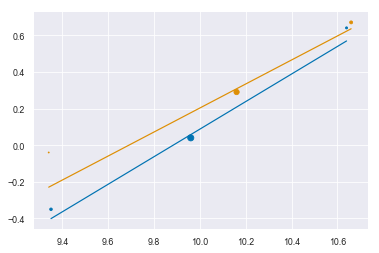

In [15]:
#weighted liner regression
import sklearn.linear_model

# model for 0.05 < z < 0.08
model1 = sklearn.linear_model.LinearRegression(fit_intercept=True)
model1.fit(mass_puer1, sfr_puer1, sample_weight=num_gals1)
line_x1 = np.linspace(min(mass_puer1), max(mass_puer1), 50).reshape((-1,1))
sfr_fit1 = model1.predict(line_x1)

# model for 0.08 < z < 0.11
model2 = sklearn.linear_model.LinearRegression(fit_intercept=True)
model2.fit(mass_puer2, sfr_puer2, sample_weight=num_gals2)
line_x2 = np.linspace(min(mass_puer2), max(mass_puer2), 50).reshape((-1,1))
sfr_fit2 = model2.predict(line_x2)

plt.scatter(mass_puer1, sfr_puer1, s=num_gals1)
plt.plot(line_x1, sfr_fit1)

plt.scatter(mass_puer2, sfr_puer2, s=num_gals2)
plt.plot(line_x2, sfr_fit2)

plt.show()

In [16]:
#general fit to all SDSS galaxies from Puertas 2018
def sfr_fit_func(x):
    return -0.03105*(x**3) + 0.892*(x**2) - 7.571*x + 17.71

x_fit = np.linspace(8.5, 11.0, 100)
sfr_fit = sfr_fit_func(x_fit)

# Build Reddening Corrected OII

In [17]:
def calzettilaw(wave):
    ''' Calzetti et al. (2000) dust attenuation curve, k(wave)
    '''
    invwv = 1/(wave/1e4)
    sel1 = np.nonzero(wave < 0.63e4)[0]
    sel2 = np.nonzero(np.logical_and(wave >= 0.63e4, wave < 2.2e4))[0]
    k1 = np.zeros(sel1.shape)
    k2 = np.zeros(sel2.shape)
    k1 = (2.659 * (-2.156 + 1.509 * invwv[sel1] - 0.198 * invwv[sel1]**2 +
          0.011 * invwv[sel1]**3) + 4.05)
    k2 = 2.659*(-1.857 + 1.040*invwv[sel2]) + 4.05
    k = np.zeros(wave.shape)
    k[sel1] = k1
    k[sel2] = k2
    return k

k_o2 = calzettilaw(np.array([3727.]))[0]

In [18]:
def red_correct(Fo, Ebv, k):
    Fi = Fo*(10**(0.4*Ebv*k))
    return Fi

hps['OII_corr'] = red_correct(hps['[OII]3727'], hps['E(B-V)'], k_o2)
fac = 10**(0.4*hps['E(B-V)']*k_o2)
hps['OII_corr_eu'] = np.sqrt((fac*hps['[OII]3727_e'])**2 + (hps['[OII]3727']*0.4*k_o2*np.log(10)*fac*hps['E(B-V)_eu'])**2)
hps['OII_corr_el'] = np.sqrt((fac*hps['[OII]3727_e'])**2 + (hps['[OII]3727']*0.4*k_o2*np.log(10)*fac*hps['E(B-V)_el'])**2)
#print hps.loc[:,['[OII]3727', 'OII_corr', '[OII]3727_e', 'E(B-V)_err', 'OII_corr_e']]

gp['OII_corr'] = red_correct(gp['[OII]3727'], gp['E(B-V)'], k_o2)
fac_gp = 10**(0.4*gp['E(B-V)']*k_o2)
gp['OII_corr_eu'] = np.sqrt((fac_gp*gp['[OII]3727_e'])**2 + (gp['[OII]3727']*0.4*k_o2*np.log(10)*fac_gp*gp['E(B-V)_eu'])**2)
gp['OII_corr_el'] = np.sqrt((fac_gp*gp['[OII]3727_e'])**2 + (gp['[OII]3727']*0.4*k_o2*np.log(10)*fac_gp*gp['E(B-V)_el'])**2)


# Calculate SFR

In [19]:
#calculated luminosity distance for each object based on its redshift

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
def z_to_Ld(z):
    Ld = cosmo.luminosity_distance(z) 
    Ld = Ld*3.086e+24
    return Ld

hps['Lum_dist'] = z_to_Ld(hps['z'])
gp['Lum_dist']  = z_to_Ld(gp['z'])


In [20]:
#SFR([O ii])(M⊙ yr−1) = (6.53±1.65)×10−42L([O ii])(erg s−1)

def SFR_red_corr(flux_o, lum_dist):
    L = flux_o*(4*math.pi)*(lum_dist**2)
    sfr = 6.58e-42*L
    return sfr
    
hps['SFR'] = SFR_red_corr(hps['OII_corr']*1e-16, hps['Lum_dist'])
gp['SFR']  = SFR_red_corr(gp['OII_corr']*1e-16, gp['Lum_dist'])

In [21]:
def SFR_met_corr(flux_o, lum_dist, met):
    a, b = -2.29, 21.21
    L = flux_o*(4*math.pi)*(lum_dist**2)
    sfr = 7.9e-42*L
    sfr_corr = sfr/(a*met+b)
    return sfr_corr

hps['SFR_met_corr'] = SFR_met_corr(hps['OII_corr']*1e-16, hps['Lum_dist'], hps['metallicity'])
gp['SFR_met_corr']  = SFR_met_corr(gp['OII_corr']*1e-16, gp['Lum_dist'], gp['metallicity'])

#print hps.loc[:,['HPS_name', 'z', 'LogM', 'metallicity', 'SFR', 'SFR_met_corr',]]

In [22]:
#calculate error in SFR

def SFR_met_corr_e(sfr, flux_o, met, flux_o_e, met_e):
    a, b = -2.29, 21.21
    a_e, b_e = 0.41, 3.66
    sfr_num = 7.9e-42
    sfr_dem = (a*met+b)
    
    e = sfr*np.sqrt(((a_e/a)**2)+((b_e/b)**2)+((flux_o_e/flux_o)**2)+((met_e/met)**2))
    
    return e

hps['SFR_met_corr_eu'] = SFR_met_corr_e(hps['SFR'], hps['OII_corr']*1e-16, hps['metallicity'], hps['OII_corr_eu']*1e-16, hps['met_eu'])
hps['SFR_met_corr_el'] = SFR_met_corr_e(hps['SFR'], hps['OII_corr']*1e-16, hps['metallicity'], hps['OII_corr_el']*1e-16, hps['met_el'])
#print hps.loc[:,['SFR_met_corr','SFR_met_corr_e']]

gp['SFR_met_corr_eu'] = SFR_met_corr_e(gp['SFR'], gp['OII_corr']*1e-16, gp['metallicity'], gp['OII_corr_eu']*1e-16, gp['met_eu'])
gp['SFR_met_corr_el'] = SFR_met_corr_e(gp['SFR'], gp['OII_corr']*1e-16, gp['metallicity'], gp['OII_corr_el']*1e-16, gp['met_el'])

def SFR_e(sfr, flux_o, flux_o_e):
    sfr_e = sfr*np.sqrt(((1.65e-42/6.58e-42)**2)+((flux_o_e/flux_o)**2))
    return sfr_e

hps['SFR_eu'] = SFR_e(hps['SFR'], hps['OII_corr']*1e-16, hps['OII_corr_eu']*1e-16)
hps['SFR_el'] = SFR_e(hps['SFR'], hps['OII_corr']*1e-16, hps['OII_corr_el']*1e-16)
print hps.loc[:,['SFR_met_corr','z','Detect']]

gp['SFR_eu'] = SFR_e(gp['SFR'], gp['OII_corr']*1e-16, gp['OII_corr_eu']*1e-16)
gp['SFR_el'] = SFR_e(gp['SFR'], gp['OII_corr']*1e-16, gp['OII_corr_el']*1e-16)

    SFR_met_corr       z      Detect
0       4.662207  0.1121   [OII]3727
1       7.876037  0.0841   [OII]3727
2       0.731983  0.1094   [OII]3727
3       1.647632  0.1027   [OII]3727
4       3.275879  0.1231   [OII]3727
5       1.118442  0.1243   [OII]3727
6       1.749463  0.1226   [OII]3727
7       1.454570  0.1222   [OII]3727
8       4.568863  0.0786   [OII]3727
9       1.442872  0.0891   [OII]3727
10      5.230194  0.1389   [OII]3727
11      0.667778  0.0887   [OII]3727
12      3.341163  0.1359   [OII]3727
13      0.686464  0.1191   [OII]3727
14      1.750147  0.1123   [OII]3727
15      0.565732  0.1072   [OII]3727
16      3.637647  0.1121   [OII]3727
17      1.147778  0.1377   [OII]3727
18      5.347543  0.1118   [OII]3727
19      0.427104  0.0929   [OII]3727
20      0.830811  0.1317   [OII]3727
21      0.689013  0.1230   [OII]3727
22      0.322186  0.1063   [OII]3727
23      1.074380  0.1159   [OII]3727
24      0.842040  0.1448   [OII]3727
25      1.388935  0.1362   [OII]3727
2

In [23]:
hps['log_SFR_met_corr'] = np.log10(hps['SFR_met_corr'])
hps['log_SFR_met_corr_el'] = 0.434*hps['SFR_met_corr_el']/hps['SFR_met_corr']
hps['log_SFR_met_corr_eu'] = 0.434*hps['SFR_met_corr_eu']/hps['SFR_met_corr']

In [24]:
gp['log_SFR_met_corr'] = np.log10(gp['SFR_met_corr'])
gp['log_SFR_met_corr_el'] = 0.434*gp['SFR_met_corr_el']/gp['SFR_met_corr']
gp['log_SFR_met_corr_eu'] = 0.434*gp['SFR_met_corr_eu']/gp['SFR_met_corr']

In [25]:
#add log values of SFRs

In [26]:
print(hps.loc[:, ['LogM_eu', 'met_eu', 'E(B-V)_eu',]])

    LogM_eu    met_eu  E(B-V)_eu
0     0.127  0.101926   0.153066
1     0.100  0.099669   0.147990
2     0.098  0.135156   0.161233
3     0.113  0.101564   0.154612
4     0.072  0.102356   0.151050
5     0.076  0.107515   0.156370
6     0.090  0.135444   0.159118
7     0.075  0.106403   0.152583
8     0.071  0.097483   0.148832
9     0.085  0.103369   0.149293
10    0.075  0.100742   0.154731
11    0.069  0.115013   0.155357
12    0.067  0.091937   0.148908
13    0.108  0.113949   0.158125
14    0.118  0.163672   0.170770
15    0.124  0.120615   0.163691
16    0.108  0.118425   0.154295
17    0.102  0.169193   0.163729
18    0.118  0.130482   0.163682
19    0.078  0.119654   0.161940
20    0.059  0.214127   0.168994
21    0.092  0.185500   0.167093
22    0.085  0.135438   0.165832
23    0.075  0.102364   0.154007
24    0.087  0.148848   0.167185
25    0.090  0.124999   0.165681
26    0.085  0.115274   0.163485
27    0.075  0.291457   0.176862
28    0.086  0.651013   0.181013


In [27]:
#mannucci 2010 SF MS
man_sfr   = np.load('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/mannucci_oii_sfr.npy')
man_sfr_e = np.load('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/mannucci_oii_sfr_error.npy')
man_mass  = np.load('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/mannucci_oii_masses.npy')

In [28]:
#andrews 2013 SF MS
andrews = pd.read_csv('/Users/Briana/Documents/Grad_School/HPS/comparison_populations/SDSS_MZR/andrews_flux_table.csv')
andrews_mb = andrews[np.isnan(andrews['logSFRlo'])]
OII_and_sfr = 0.97*andrews_mb['logSFR']-0.03

In [29]:
#duarte puertas 2017 SF MS [OII]
DP_oii_sfr = np.load('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/duartepuertas_oii_sfr.npy')

In [30]:
hps.to_csv('/Users/Briana/Documents/Grad_School/HPS/HPS_dataframes/HPS_flux_prop_table.csv')

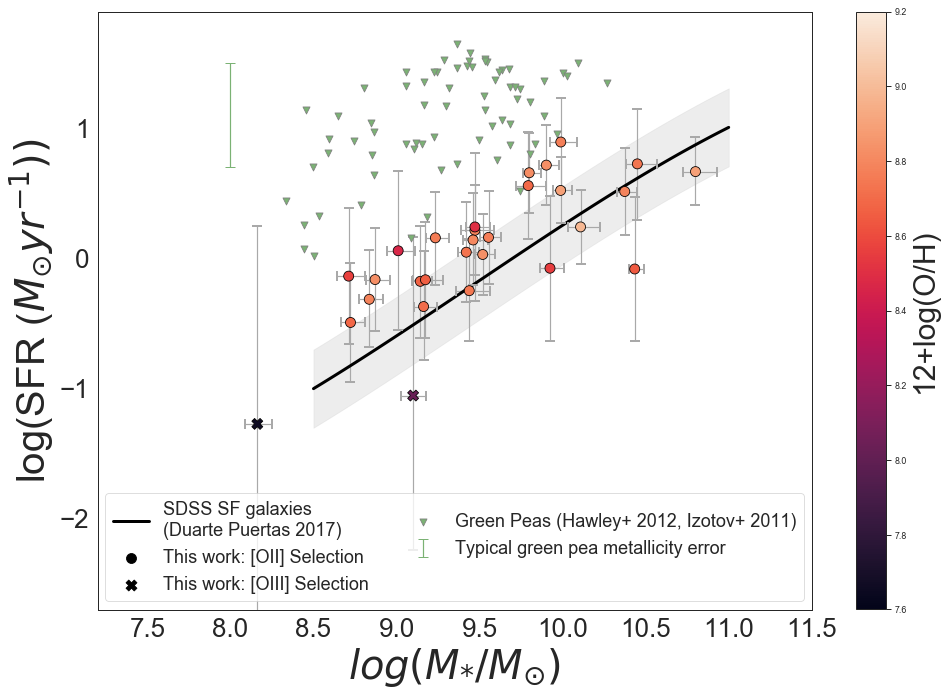

In [62]:
sns.set_style("white")
plt.figure(figsize=(16,11))
ax = plt.gca()

sfr_vals = 'SFR_met_corr'

hps_O2 = hps[hps['Detect'] == '[OII]3727']
hps_O3 = hps[hps['Detect'] == '[OIII]5007']

log_sfr_el_o2 = 0.434*hps_O2[sfr_vals+'_el']/hps_O2[sfr_vals]
log_sfr_eu_o2 = 0.434*hps_O2[sfr_vals+'_eu']/hps_O2[sfr_vals]
log_sfr_el_o3 = 0.434*hps_O3[sfr_vals+'_el']/hps_O3[sfr_vals]
log_sfr_eu_o3 = 0.434*hps_O3[sfr_vals+'_eu']/hps_O3[sfr_vals]

#my_cmap = ListedColormap(sns.cubehelix_palette(100,light=1).as_hex())
my_cmap='magma'

#plot the sdss curve 
#Duarte Puertas 2017
# sdss, = plt.plot(x_fit, sfr_fit, color='purple', lw=3) # label='SDSS SF galaxies'+'\n'+'(Duarte Puertas 2017)')
# plt.fill_between(x_fit, sfr_fit+0.3, sfr_fit-0.3, color='lightgrey', alpha=0.4, label='_nolegend_')

#Duarte Puertas 2017 [OII]
sdss, = plt.plot(x_fit, DP_oii_sfr, color='black', lw=3, label='SDSS SF galaxies'+'\n'+'(Duarte Puertas 2017)')
plt.fill_between(x_fit, DP_oii_sfr+0.3, DP_oii_sfr-0.3, color='lightgrey', alpha=0.4, label='_nolegend_')

#Mannucci 2010
# sdss, = plt.plot(man_mass, man_sfr, color='black', lw=3, label='SDSS SF galaxies'+'\n'+'(Mannucci+ 2010)')
# plt.fill_between(man_mass, man_sfr+man_sfr_e, man_sfr-man_sfr_e, color='lightgrey', alpha=0.4, label='_nolegend_')

#Andrews 2013
#sdss, = plt.plot(andrews_mb['logM*'], OII_and_sfr, color='black', lw=3, label='SDSS SF galaxies'+'\n'+'(Mannucci+ 2010)')
#plt.fill_between(man_mass, man_sfr+man_sfr_e, man_sfr-man_sfr_e, color='lightgrey', alpha=0.4, label='_nolegend_')


#plot My data
o2 = plt.scatter(hps_O2["LogM"], np.log10(hps_O2['SFR_met_corr']), c=hps_O2['metallicity'], s=100, edgecolors='black', marker='o', vmin=7.6, vmax=9.2, label='This work: [OII] Selection', zorder=2000)
o3 = plt.scatter(hps_O3["LogM"], np.log10(hps_O3['SFR_met_corr']), c=hps_O3['metallicity'], s=120, edgecolors='black', marker='X', vmin=7.6, vmax=9.2, label='This work: [OIII] Selection',zorder=2001)

plt.errorbar(hps_O2["LogM"], np.log10(hps_O2['SFR_met_corr']), xerr=(hps_O2['LogM_el'], hps_O2['LogM_eu']), yerr=(log_sfr_el_o2, log_sfr_eu_o2), capsize=5, capthick=2, color='darkgrey', ls='None', label='_nolegend_')
plt.errorbar(hps_O3["LogM"], np.log10(hps_O3['SFR_met_corr']), xerr=(hps_O3['LogM_el'], hps_O3['LogM_eu']), yerr=(log_sfr_el_o3, log_sfr_eu_o3), capsize=5, capthick=2, color='darkgrey', ls='None', label='_nolegend_')

cbar = plt.colorbar()
cbar.set_label('12+log(O/H)', fontsize=30)

#plot the secondary measurements of SFR in grey
#plt.scatter(hps_O2["LogM"], np.log10(hps_O2['SFR']), s=80, facecolors='grey', edgecolors='DimGray', marker='o', label='This work: w/o Metallicity Correction')
#plt.scatter(hps_O3["LogM"], np.log10(hps_O3['SFR']), s=100, facecolors='grey', edgecolors='DimGray', marker='X', label='_nolegend_')

#gp
colors_gp = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
gp_c = sns.xkcd_palette(colors_gp)
log_sfr_el_gp = 0.434*gp[sfr_vals+'_el']/gp[sfr_vals]
log_sfr_eu_gp = 0.434*gp[sfr_vals+'_eu']/gp[sfr_vals]
gp_mass_cab = np.log10((10**gp["logM"]) * 0.61)
gp_p = plt.scatter(gp_mass_cab, np.log10(gp['SFR_met_corr']), s=50, color=gp_c[3], edgecolors='grey', marker='v', label='Green Peas (Hawley+ 2012, Izotov+ 2011)',zorder=1001)
gp_e = plt.errorbar([8.0], [1.1], yerr=([np.average(log_sfr_el_gp)], [np.average(log_sfr_eu_gp)]), capsize=5, capthick=1, color=gp_c[3], ls='None', label='Typical green pea metallicity error')

plt.tick_params(axis='both', which='major', labelsize=26)
plt.ylabel(r'log(SFR ($M_{\odot} yr^{-1}))$', fontsize=40)
plt.xlabel(r'$log(M_{*}/M_{\odot})$', fontsize=40)

# plt.scatter(mass_puer1, sfr_puer1, color='maroon', s=num_gals1*5)
# plt.plot(line_x1, sfr_fit1, color='black', linestyle=':',label='SDSS 0.05<z<0.08 (Duarte Puertas 2017)')

# plt.scatter(mass_puer2, sfr_puer2, color='coral', s=num_gals2*5)
# plt.plot(line_x2, sfr_fit2, color='black', linestyle='--', label='SDSS 0.08<z<0.11 (Duarte Puertas 2017)')

#plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.27), fontsize=20, ncol=2)
plt.legend(loc='lower center', fontsize=18, ncol=2)
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

plt.ylim(-2.7, 1.9)
plt.xlim(7.2, 11.5)

plt.savefig(os.path.join(plot_path, 'SFR_vs_mass.pdf'), bbox_inches='tight')

In [81]:
def build_obj_df(sfr, mass, sfr_e, mass_e, obj):
    obj_df = pd.DataFrame(columns=['log(SFR)', 'log(M*)', 'log(SFR)_error', 'log(M*)_error', 'Object_Type'])
    obj_df['log(SFR)'] = sfr
    obj_df['log(M*)'] = mass
    obj_df['log(SFR)_error'] = sfr_e
    obj_df['log(M*)_error'] = mass_e
    obj_df['Object_Type'] = obj
    return obj_df


o2_met_e = [str((log_sfr_el_o2[i], log_sfr_eu_o2[i])) for i in range(len(log_sfr_el_o2))]
o2_mas_e = [str((hps_O2['LogM_el'].iloc[i], hps_O2['LogM_eu'].iloc[i])) for i in range(len(log_sfr_el_o2))]
plt_df_hpso2 = build_obj_df(np.log10(hps_O2['SFR_met_corr']), hps_O2["LogM"], o2_met_e, o2_mas_e, 'HPS_OII')

o3_met_e = [str((log_sfr_el_o3.iloc[i], log_sfr_eu_o3.iloc[i])) for i in range(len(log_sfr_el_o3))]
o3_mas_e = [str((hps_O3['LogM_el'].iloc[i], hps_O3['LogM_eu'].iloc[i])) for i in range(len(log_sfr_el_o3))]
plt_df_hpso3 = build_obj_df(np.log10(hps_O3['SFR_met_corr']), hps_O3["LogM"], o3_met_e, o3_mas_e, 'HPS_OIII')

gp_met_e = [str((log_sfr_el_gp.iloc[i], log_sfr_eu_gp.iloc[i])) for i in range(len(log_sfr_el_gp))]
plt_df_gp = build_obj_df(np.log10(gp['SFR_met_corr']), gp_mass_cab, gp_met_e, None, 'Green_Pea')

sdss_met_e = [str((DP_oii_sfr[i]-0.3, DP_oii_sfr[i]+0.3)) for i in range(len(DP_oii_sfr))]
plt_df_sdss = build_obj_df(x_fit, DP_oii_sfr, sdss_met_e, None, 'SDSS_SF_Galaxies')

frames = [plt_df_hpso2, plt_df_hpso3, plt_df_sdss, plt_df_gp]
mzr_plt_data = pd.concat(frames)
print(plot_path+'SFR_vs_mass_data.csv')
mzr_plt_data.to_csv(plot_path+'/SFR_vs_mass_data.csv')

/Users/Briana/Documents/Grad_School/HPS/Paper_PlotsSFR_vs_mass_data.csv


# Compare SFR Methods

-0.0195538613188 0.149966833911
0.0107806461168 0.100561814887
-0.4290697117 0.0808727708245


         SFR  SFR_met_corr
27  0.207864      0.088287
27   -0.371884
dtype: float64


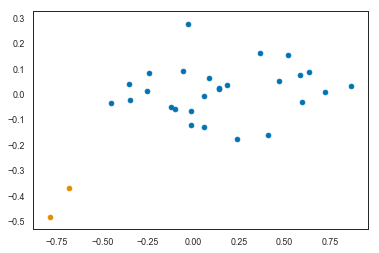

In [33]:
sns.set_style("white")
diff = np.log10(hps['SFR_met_corr'])-np.log10(hps['SFR'])
print diff.mean(), diff.std()

diff_O2 = np.log10(hps_O2['SFR_met_corr'])-np.log10(hps_O2['SFR'])
diff_O3 = np.log10(hps_O3['SFR_met_corr'])-np.log10(hps_O3['SFR'])

plt.scatter(np.log10(hps_O2['SFR']), diff_O2)
plt.scatter(np.log10(hps_O3['SFR']), diff_O3)

O3_obj = hps[hps['HPS_name']=='HPS100021+021351'].loc[:,['SFR', 'SFR_met_corr']]
diff_obj = np.log10(O3_obj['SFR_met_corr']) - np.log10(O3_obj['SFR'])

print diff_O2.mean(), diff_O2.std()
print diff_O3.mean(), diff_O3.std()
print '\n'
print O3_obj
print diff_obj

# Specific Star Formation Rates (sSFR)

    only using metallicity corrected SFR

In [34]:
#calculate sSFR (SFR/M)
unlog_mass_O2 = 10**hps_O2["LogM"]
unlog_mass_O3 = 10**hps_O3["LogM"]

unlog_mass_O2_el = 10**hps_O2["LogM_el"]
unlog_mass_O2_eu = 10**hps_O2["LogM_eu"]
unlog_mass_O3_el = 10**hps_O3["LogM_el"]
unlog_mass_O3_eu = 10**hps_O3["LogM_eu"]

sSFR_O2 = hps_O2['SFR_met_corr']/unlog_mass_O2
sSFR_O3 = hps_O3['SFR_met_corr']/unlog_mass_O3

In [35]:
#calculate sSFR errors
def log_sSFR_e(ssfr, sfr, sfr_e, mass, mass_e):
    ssfr_e = ssfr*np.sqrt(((sfr_e/sfr)**2)+((mass_e/mass)**2))
    log_ssfr_e = 0.434*ssfr_e/ssfr
    return log_ssfr_e

log_ssfr_el_o2 = log_sSFR_e(sSFR_O2, hps_O2['SFR_met_corr'], hps_O2['SFR_met_corr_el'], unlog_mass_O2, unlog_mass_O2_el)
log_ssfr_eu_o2 = log_sSFR_e(sSFR_O2, hps_O2['SFR_met_corr'], hps_O2['SFR_met_corr_eu'], unlog_mass_O2, unlog_mass_O2_eu)
log_ssfr_el_o3 = log_sSFR_e(sSFR_O3, hps_O3['SFR_met_corr'], hps_O3['SFR_met_corr_el'], unlog_mass_O3, unlog_mass_O3_el)
log_ssfr_eu_o3 = log_sSFR_e(sSFR_O3, hps_O3['SFR_met_corr'], hps_O3['SFR_met_corr_eu'], unlog_mass_O3, unlog_mass_O3_eu)

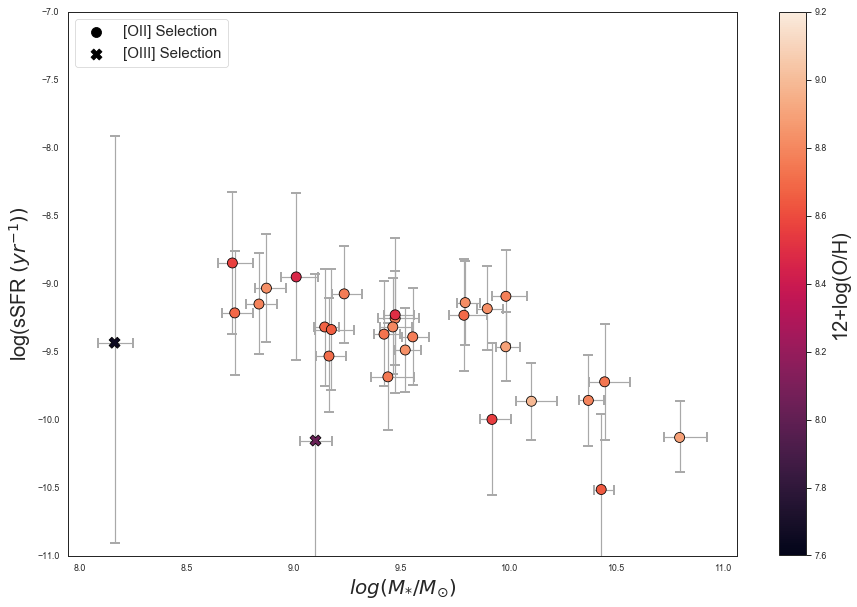

In [36]:
plt.figure(figsize=(15,10))
ax = plt.gca()

plt.scatter(hps_O2["LogM"], np.log10(sSFR_O2), c=hps_O2['metallicity'], s=100, edgecolors='black', marker='o', vmin=7.6, vmax=9.2, label='[OII] Selection', zorder=1000)
plt.scatter(hps_O3["LogM"], np.log10(sSFR_O3), c=hps_O3['metallicity'], s=120, edgecolors='black', marker='X', vmin=7.6, vmax=9.2, label='[OIII] Selection',zorder=1001)

plt.errorbar(hps_O2["LogM"], np.log10(sSFR_O2), xerr=(hps_O2['LogM_el'], hps_O2['LogM_eu']), yerr=(log_ssfr_el_o2, log_ssfr_eu_o2), capsize=5, capthick=2, color='darkgrey', ls='None', label='_nolegend_')
plt.errorbar(hps_O3["LogM"], np.log10(sSFR_O3), xerr=(hps_O3['LogM_el'], hps_O3['LogM_eu']), yerr=(log_ssfr_el_o3, log_ssfr_eu_o3), capsize=5, capthick=2, color='darkgrey', ls='None', label='_nolegend_')

cbar = plt.colorbar()
cbar.set_label('12+log(O/H)', fontsize=20)

plt.ylabel(r'log(sSFR $(yr^{-1}))$', fontsize=20)
plt.xlabel(r'$log(M_{*}/M_{\odot})$', fontsize=20)

plt.legend(loc=2, fontsize=15)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')

plt.ylim(-11, -7)

plt.savefig(os.path.join(plot_path, 'sSFR_vs_mass.png'))

# Limits of SFR Detections with HETDEX


In [37]:
HDX_flux_lim = 3.5e-17 #erg/s/cm^2
hi_z  = 0.1

hi_ld = z_to_Ld(hi_z)
med_ld = hi_ld/2.0

dist_sfr = SFR_red_corr(HDX_flux_lim, hi_ld).value
med_sfr  = SFR_red_corr(HDX_flux_lim, med_ld).value

print 'SFR limit at highest z: ', dist_sfr, 'Mo/yr'
print 'SFR limit at median dist: ', med_sfr, 'Mo/yr'

SFR limit at highest z:  0.00583952436979 Mo/yr
SFR limit at median dist:  0.00145988109245 Mo/yr


In [38]:
# 0.001531  0.0917 
# 0.005989  0.0889

sfr_1 = SFR_red_corr(HDX_flux_lim, z_to_Ld(0.0917)).value
sfr_2 = SFR_red_corr(HDX_flux_lim, z_to_Ld(0.0889)).value
print sfr_1
print sfr_2

0.00485571496014
0.00454636775971


# Fundamental Metallicity Relation (FMR)

(7.6, 11.0)

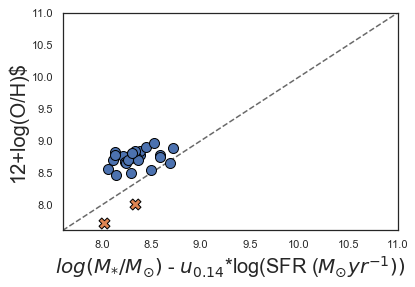

In [99]:
def find_y(LogM, sfr):
    #y = LogM - 0.32*(np.log10(sfr)) #mannucci 2010 (SDSS)
    #y = LogM - 0.66*(np.log10(sfr)) #andrews 2013 (SDSS)
    #y = -0.12*np.log10(sfr)+0.33*LogM+5.20 #hunt 2012 (LCD galaxies)
    y = -0.14*np.log10(sfr)+0.37*LogM+4.82 #Hunt 2016 (low metal starbursts)
    return y 

alpha = 0.14
plt.scatter(find_y(hps_O2["LogM"],hps_O2[sfr_vals]), hps_O2['metallicity'], s=100, edgecolors='black', marker='o', vmin=7.6, vmax=9.2, label='[OII] Selection', zorder=1000)
plt.scatter(find_y(hps_O3["LogM"],hps_O3[sfr_vals]), hps_O3['metallicity'], s=120, edgecolors='black', marker='X', vmin=7.6, vmax=9.2, label='[OIII] Selection',zorder=1001)

plt.ylabel(r'12+log(O/H)$', fontsize=20)
plt.xlabel(r'$log(M_{*}/M_{\odot})$ - $u_{'+str(alpha)+'}$*log(SFR ($M_{\odot} yr^{-1}))$', fontsize=20)
#plt.legend(loc=2, fontsize=15)

ran = [7.6, 11.0]

plt.plot(np.arange(ran[0],ran[1]+2), np.arange(ran[0],ran[1]+2), color='DimGray', linestyle='--')

plt.ylim(ran[0],ran[1])
plt.xlim(ran[0],ran[1])